<a href="https://colab.research.google.com/github/ayush9h/PyTorch-DeepLearning/blob/main/Meta_Parameters_Activations%2C_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install scikit-learn

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

import scipy.stats as stats
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0

data['boolQuality'][data['quality']>5] = 1


/tmp/ipython-input-1666556559.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
/tmp/ipython-input-1666556559.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [8]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()

labels = labels[:,None]

In [10]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

from torch.utils.data import DataLoader

train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [11]:
class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    self.input = nn.Linear(11,16)

    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    self.output = nn.Linear(32,1)

    self.actfun = actfun

  def forward(self,x):

    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

In [12]:
numepochs = 1000
import numpy as np
def trainTheModel():

  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.001)

  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  for epochi in range(numepochs):

    winenet.train()

    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

    trainAcc.append( np.mean(batchAcc) )

    losses[epochi] = np.mean(batchLoss)

    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )


  return trainAcc,testAcc,losses


In [13]:
activation_funs = [ 'ReLU', 'ReLU6', 'LeakyReLU' ]

trainByAct = np.zeros((numepochs,len(activation_funs)))
testByAct  = np.zeros((numepochs,len(activation_funs)))

for ai,actfun in enumerate(activation_funs):
  winenet = ANNwine(actfun)
  trainByAct[:,ai],testByAct[:,ai],losses = trainTheModel()


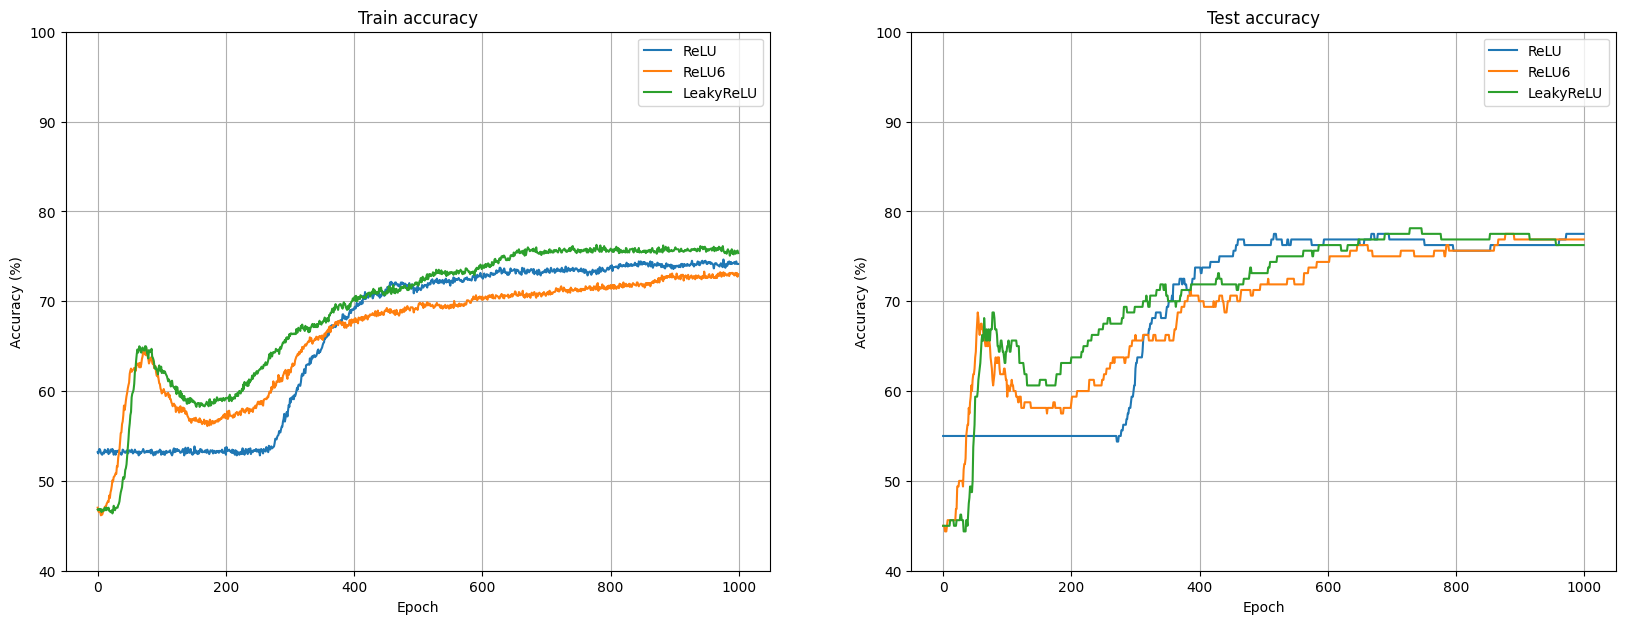

In [17]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

for i in range(2):
  ax[i].legend(activation_funs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([40,100])
  ax[i].grid()

In [18]:
# Kullback - Leibler Divergence(KL distance)
# Distance between two probability distributions

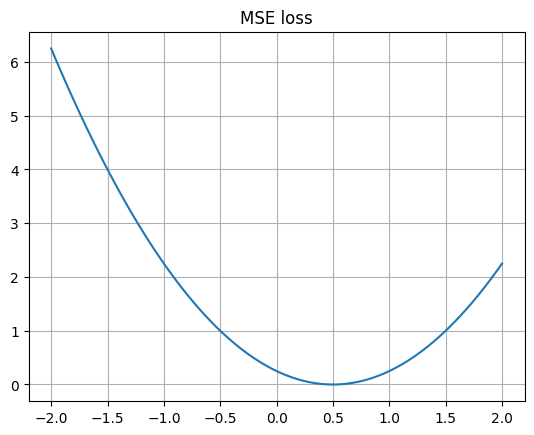

In [19]:
lossfunMse = nn.MSELoss()
yHat = torch.linspace(-2,2,101)
y = torch.tensor(0.5)

L = np.zeros(101)
for i, yy in enumerate(yHat):
  L[i] = lossfunMse(yy,y)


plt.plot(yHat,L)
plt.title('MSE loss')
plt.grid()


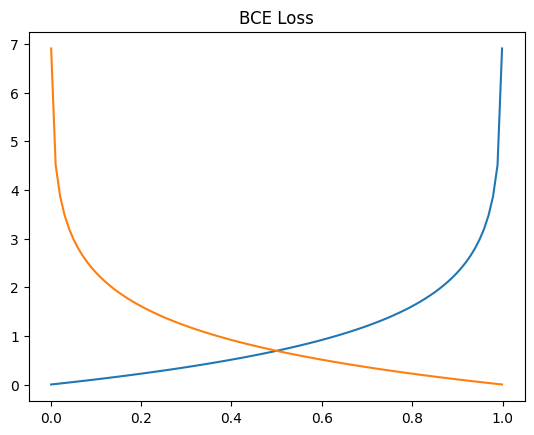

In [22]:
lossfunBCE = nn.BCELoss()

yHat = torch.linspace(.001, .999, 101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

L = np.zeros((101,2))

for i, yy in enumerate(yHat):
  L[i, 0] = lossfunBCE(yy, y1)
  L[i, 1] = lossfunBCE(yy, y2)

plt.plot(yHat, L)
plt.title("BCE Loss")
plt.show()

In [24]:
# Custom Loss function
class custLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x,y):
    loss = torch.abs(x - y)
    return loss


lfun = custLoss()
lfun(torch.tensor(5.),torch.tensor(2.))

tensor(3.)